In [1]:
import geopandas as gpd

# Data source - https://www.hydrosheds.org/products/hydrorivers
samerica_rivers = gpd.read_file("data/a00000009.gdbtable")

print(samerica_rivers)

         HYRIV_ID  NEXT_DOWN  MAIN_RIV  LENGTH_KM  DIST_DN_KM  DIST_UP_KM  \
0        60000001          0  60000001       0.97         0.0         6.5   
1        60000002          0  60000002       1.16         0.0         5.3   
2        60000003          0  60000003       3.37         0.0         7.2   
3        60000004          0  60000004       3.37         0.0         6.3   
4        60000005          0  60000005       3.07         0.0         7.9   
...           ...        ...       ...        ...         ...         ...   
1620958  61620959          0  61620959       1.72         0.0         5.4   
1620959  61620960          0  61620960       0.91         0.0         3.5   
1620960  61620961          0  61620961       1.72         0.0         4.2   
1620961  61620962          0  61620962       0.80         0.0         3.5   
1620962  61620963          0  61620963       2.57         0.0         4.2   

         CATCH_SKM  UPLAND_SKM  ENDORHEIC  DIS_AV_CMS  ORD_STRA  ORD_CLAS  

C:\Users\symmy\AppData\Local\Temp\ipykernel_6668\2106412845.py:9: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  france.geometry = [polygons[0]]
C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


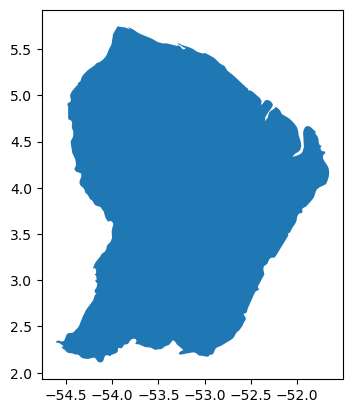

In [3]:
import pandas as pd
# Data source - https://github.com/nvkelso/natural-earth-vector/blob/master/10m_cultural/ne_10m_admin_0_countries.shp
country_shapefiles = gpd.read_file("data//ne_10m_admin_0_countries.shp")
samerica = country_shapefiles.loc[country_shapefiles['CONTINENT'] == 'South America']

france = country_shapefiles.loc[country_shapefiles['ADMIN'] == 'France']

polygons = france.iloc[0].geometry
france.geometry = [polygons[0]]
france.plot()
samerica = pd.concat([samerica, france])

In [4]:
# Data source - https://github.com/nvkelso/natural-earth-vector/blob/master/10m_physical/ne_10m_lakes.shp

lakes = gpd.read_file("data/ne_10m_lakes.shp")
lakes = lakes.loc[lakes['featurecla'] == 'Lake']
lakes = lakes.dropna(subset=['name'])

samerica_lakes = gpd.sjoin(lakes, samerica, op='intersects')
samerica_lakes = lakes.loc[lakes.index.isin(samerica_lakes.index.tolist())]
excluded_rivers = gpd.sjoin(samerica_rivers, samerica_lakes, op='within')
samerica_rivers = samerica_rivers.loc[~samerica_rivers.index.isin(excluded_rivers.index.tolist())]

C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [5]:
samerica_rivers = samerica_rivers.loc[samerica_rivers['ORD_FLOW'] < 8]

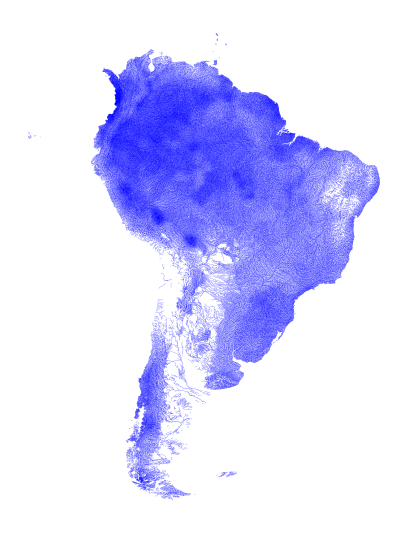

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(5, 7)

samerica_rivers.plot(ax=ax, color='blue', lw=0.1)
samerica_lakes.plot(ax=ax, color='white', alpha=1)

ax.axis('off')
plt.show()

In [7]:
import pandas as pd
import numpy as np

leftSpan = np.amax(samerica_rivers['DIST_UP_KM']) - np.amin(samerica_rivers['DIST_UP_KM'])
rightSpan = 0.6 - 0.04
valueScaled = (samerica_rivers['DIST_UP_KM'] - np.amin(samerica_rivers['DIST_UP_KM'])) / leftSpan
samerica_rivers['LW_DIST_UP_KM'] = 0.04 + (valueScaled * rightSpan)

In [8]:
import rasterio
from rasterio import mask as msk 
from shapely.geometry import mapping

forests_file = rasterio.open('data/forests.tif')

clipped_array, clipped_transform = rasterio.mask.mask(forests_file, [mapping(geom) for geom in (samerica.geometry.tolist())], 
                                                      crop=True, nodata=0)

In [9]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import cm

greens = cm.get_cmap('Greens', 101)
newcolors = greens(np.linspace(0, 1, 101))
background_colour = np.array([0.0, 0.0, 0.0, 0.0])
newcolors[:1, :] = background_colour
newcmp_forests = ListedColormap(newcolors)

bounds = np.arange(102)
norm_forests = BoundaryNorm(bounds, newcmp_forests.N)

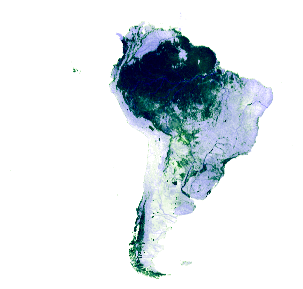

In [10]:
from rasterio.plot import show

fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)
show(clipped_array[0], ax=ax, transform=clipped_transform, cmap=newcmp_forests, norm=norm_forests)
samerica_rivers.plot(ax=ax, edgecolor='face', color='blue', lw=samerica_rivers['LW_DIST_UP_KM'], alpha=0.4)
ax.axis('off')
plt.savefig("test.png", dpi=1000, bbox_inches='tight')
plt.show()

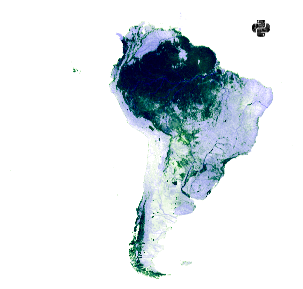

In [11]:
import matplotlib
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "gabriola"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

im = plt.imread('../Branding/light_logo.png')

from rasterio.plot import show

fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)
show(clipped_array[0], ax=ax, transform=clipped_transform, cmap=newcmp_forests, norm=norm_forests)
samerica_rivers.plot(ax=ax, edgecolor='face', color='blue', lw=samerica_rivers['LW_DIST_UP_KM'], alpha=0.4)
ax.axis('off')

newax = fig.add_axes([0.63, 0.8, 0.05, 0.05], anchor='NE')
newax.imshow(im)
newax.axis('off')

plt.show()